In [2]:
import os
import json
#from cltk import NLP 
#from cltk.core.data_types import Word, Doc, Sentence
# from collections import Counter
from tqdm import tqdm
# import pickle
import pandas as pd
from utils import word_to_simple_identifier, sentence_to_string_repr
from translations.translation_utils import get_system_msg, get_user_prompt, parse_output, find_matching_sentences, filter_matching_sentences
import numpy as np
import powerlaw

In [3]:
df_sents = pd.read_parquet("../data/sentences.parquet").drop_duplicates(subset=["sentence_txt"])
df_words = pd.read_parquet("../data/word_to_lemma.parquet")

In [4]:
text_counts = df_words.groupby("text").sum("count")
lemma_counts = df_words.groupby("lemma").sum("count")

In [181]:
pos_counts = df_words.groupby("pos").sum("count").sort_values(by="count", ascending=False)

<Axes: xlabel='pos'>

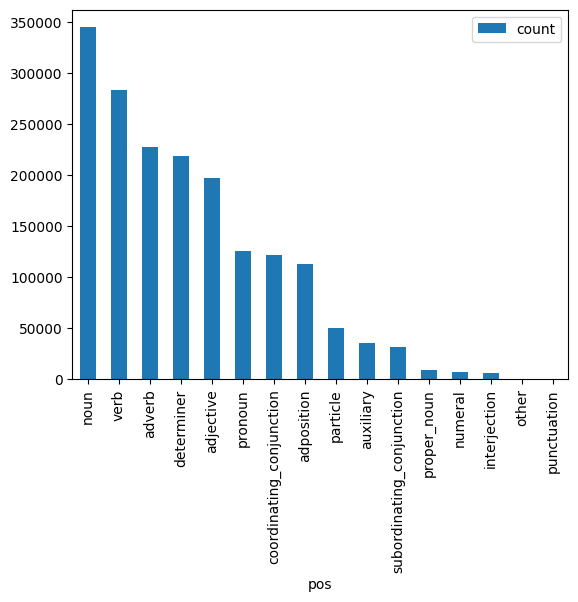

In [182]:
pos_counts.plot.bar()

In [151]:
from matplotlib import pyplot as plt
from scipy.special import zeta  
def get_zipf_array(df, topk=5000):
    df_topk = df.sort_values(by="count", ascending=False)[:topk]
    # df_topk = df_topk /  10 #df_topk.min()
    df_topk = df_topk.astype(int).reset_index()
    out_arr = []
    for i, r in df_topk.iterrows():
        out_arr.extend([i+1] * r["count"])
    return np.array(out_arr)


In [229]:
def plot_text_lemma_zipf(text_counts, lemma_counts, topk, logscale: bool=False):
    zipf_tc = get_zipf_array(text_counts, topk=topk)
    fit = powerlaw.Fit(zipf_tc, discrete=True, xmin=1)
    zipf_alpha_text = fit.alpha
    print(f"{zipf_alpha_text=}")

    zipf_lc = get_zipf_array(lemma_counts, topk=topk)
    fit = powerlaw.Fit(zipf_lc, discrete=True, xmin=1)
    zipf_alpha_lemma = fit.alpha
    print(f"{zipf_alpha_lemma=}")

    count_tc = np.bincount(zipf_tc)
    count_lc = np.bincount(zipf_lc)
    k = np.arange(1, zipf_tc.max() + 1)

    n_ctc = len(zipf_tc)
    n_clc = len(zipf_lc)

    plt.bar(k, count_lc[1:], alpha=0.5, label='lemma count')
    plt.bar(k, count_tc[1:], alpha=0.5, label='text count')
    
    plt.plot(k, n_clc*(k**-zipf_alpha_lemma)/zeta(zipf_alpha_lemma), 'b-', alpha=0.5, label=f'lemma ≃ zipf({round(zipf_alpha_lemma, 5)}, {n_clc})')
    plt.plot(k, n_ctc*(k**-zipf_alpha_text)/zeta(zipf_alpha_text), 'r-', alpha=0.5, label=f'text ≃ zipf({round(zipf_alpha_text, 5)}, {n_ctc})')
    if logscale:
        plt.yscale('log')
    
    plt.title(f"zipf estimation for top {topk} lemmas and words by frequency")
    plt.xlabel("rank")
    plt.ylabel("frequency")
    plt.xticks(range(0, topk+1, int(topk/10)))
    plt.legend()

    plt.savefig(f"zipf_top_{topk}_{'log' if logscale else 'lin'}.png")
    plt.show()

zipf_alpha_text=1.4486969126969473
zipf_alpha_lemma=1.5301374624858468


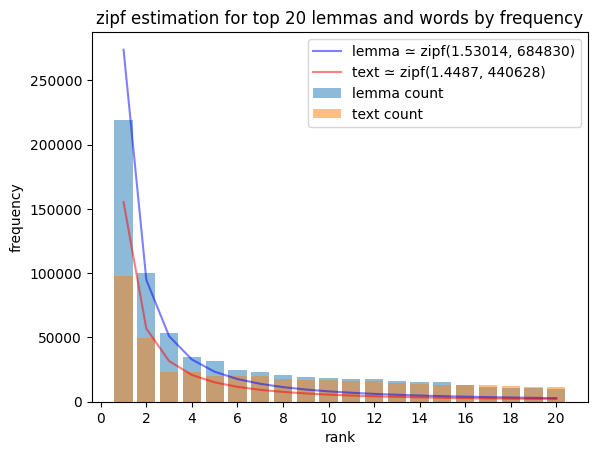

In [230]:
plot_text_lemma_zipf(text_counts, lemma_counts, 20, logscale=False)

zipf_alpha_text=1.253576725680934
zipf_alpha_lemma=1.284415504423757


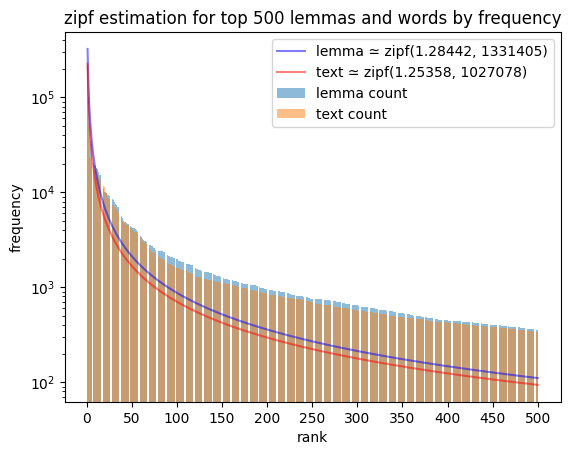

In [231]:
plot_text_lemma_zipf(text_counts, lemma_counts, 500, logscale=True)

In [36]:
(100 * text_counts / text_counts.sum()).sort_values(by="count", ascending=False)#.cumsum()

,count
text,
καὶ,5.532591
δὲ,2.796108
τῶν,1.324992
μὲν,1.305908
τὴν,1.142733
...,...
ναυμαχοῦντας,0.000113
ναυπηγήσιμα,0.000113
ναυσίπορος,0.000113


In [7]:
(100 * lemma_counts / lemma_counts.sum()).sort_values(by="count", ascending=False).cumsum()

,count
lemma,
ὁ,12.383286
καί,18.031455
δέ,21.068090
εἰμί,23.039120
αὐτός,24.840933
...,...
προσηγόρευσον,99.999548
προσηγόρευον,99.999661
προσηγορεύθησαν,99.999774


In [8]:
(100 * df_words["count"] / df_words["count"].sum())[:7000].sum()

79.40805316454981